# Predicting Housing Prices


In [69]:
# Run this cell to suppress all FutureWarnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [123]:
import numpy as np

import pandas as pd

from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

# The Data

The [Ames dataset](http://jse.amstat.org/v19n3/decock.pdf) consists of 2930 records taken from the Ames, Iowa Assessor’s Office describing houses sold in Ames from 2006 to 2010.  The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total.  An explanation of each variable can be found in the included `codebook.txt` file.  The information was used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010.  **Some noise has been added to the actual sale price, so prices will not match official records.**

The data are split into training and test sets with 2000 and 930 observations, respectively.

In [71]:
training_data = pd.read_csv("ames_train.csv")
test_data = pd.read_csv("ames_test.csv")

As a good sanity check, we should at least verify that the data shape matches the description.

In [72]:
# 2000 observations and 82 features in training data
assert training_data.shape == (2000, 82)
# 930 observations and 81 features in test data
assert test_data.shape == (930, 81)
# SalePrice is hidden in the test data
assert 'SalePrice' not in test_data.columns.values
# Every other column in the test data should be in the training data
assert len(np.intersect1d(test_data.columns.values, 
                          training_data.columns.values)) == 81

The next order of business is getting a feel for the variables in our data.  The Ames data set contains information that typical homebuyers would want to know.  A more detailed description of each variable is included in `codebook.txt`.  **You should take some time to familiarize yourself with the codebook before moving forward.**

# Part 1: Exploratory Data Analysis

In this section, we will make a series of exploratory visualizations and interpret them.

Note that we will perform EDA on the **training data** so that information from the test data does not influence our modeling decisions.

### Sale Price
We begin by examining a [raincloud plot](https://micahallen.org/2018/03/15/introducing-raincloud-plots/amp/?__twitter_impression=true) (a combination of a KDE, a histogram, a strip plot, and a box plot) of our target variable `SalePrice`.  At the same time, we also take a look at some descriptive statistics of this variable.

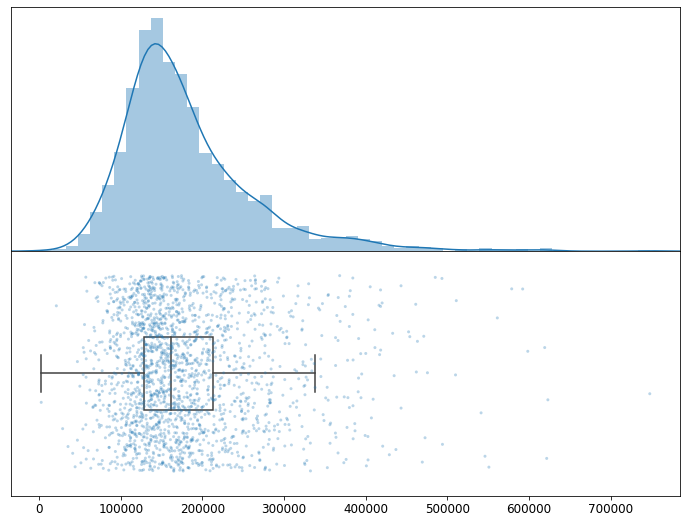

In [73]:
fig, axs = plt.subplots(nrows=2)

sns.distplot(
    training_data['SalePrice'].values, 
    ax=axs[0]
)
sns.stripplot(
    training_data['SalePrice'].values, 
    jitter=0.4, 
    size=3,
    ax=axs[1],
    alpha=0.3
)
sns.boxplot(
    training_data['SalePrice'].values,
    width=0.3, 
    ax=axs[1],
    showfliers=False,
)

# Align axes
spacer = np.max(training_data['SalePrice']) * 0.05
xmin = np.min(training_data['SalePrice']) - spacer
xmax = np.max(training_data['SalePrice']) + spacer
axs[0].set_xlim((xmin, xmax))
axs[1].set_xlim((xmin, xmax))

# Remove some axis text
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

# Put the two plots together
plt.subplots_adjust(hspace=0)

# Adjust boxplot fill to be white
axs[1].artists[0].set_facecolor('white')

In [74]:
training_data['SalePrice'].describe()

count      2000.000000
mean     180775.897500
std       81581.671741
min        2489.000000
25%      128600.000000
50%      162000.000000
75%      213125.000000
max      747800.000000
Name: SalePrice, dtype: float64

The mean of SalePrice in the Training set is greater than the median implying a right-skewed distribution. Atleast 25% of the houses in the training set sold for more than $200,000

This function removes outliers from our data with only observations that satisfy Gr_Liv_Area less than 5000.

In [75]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (data frame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than or equal to this will be removed
    
    Output:
      a winsorized data frame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data.loc[(data[variable] > lower) & (data[variable] < upper), :]

training_data_no_outliers = remove_outliers(training_data, 'Gr_Liv_Area', upper=5000)

# Multicollinearity

We use a correlation heatmap to detect if any of the variables are correlated as that will cause problems for our regression analysis.

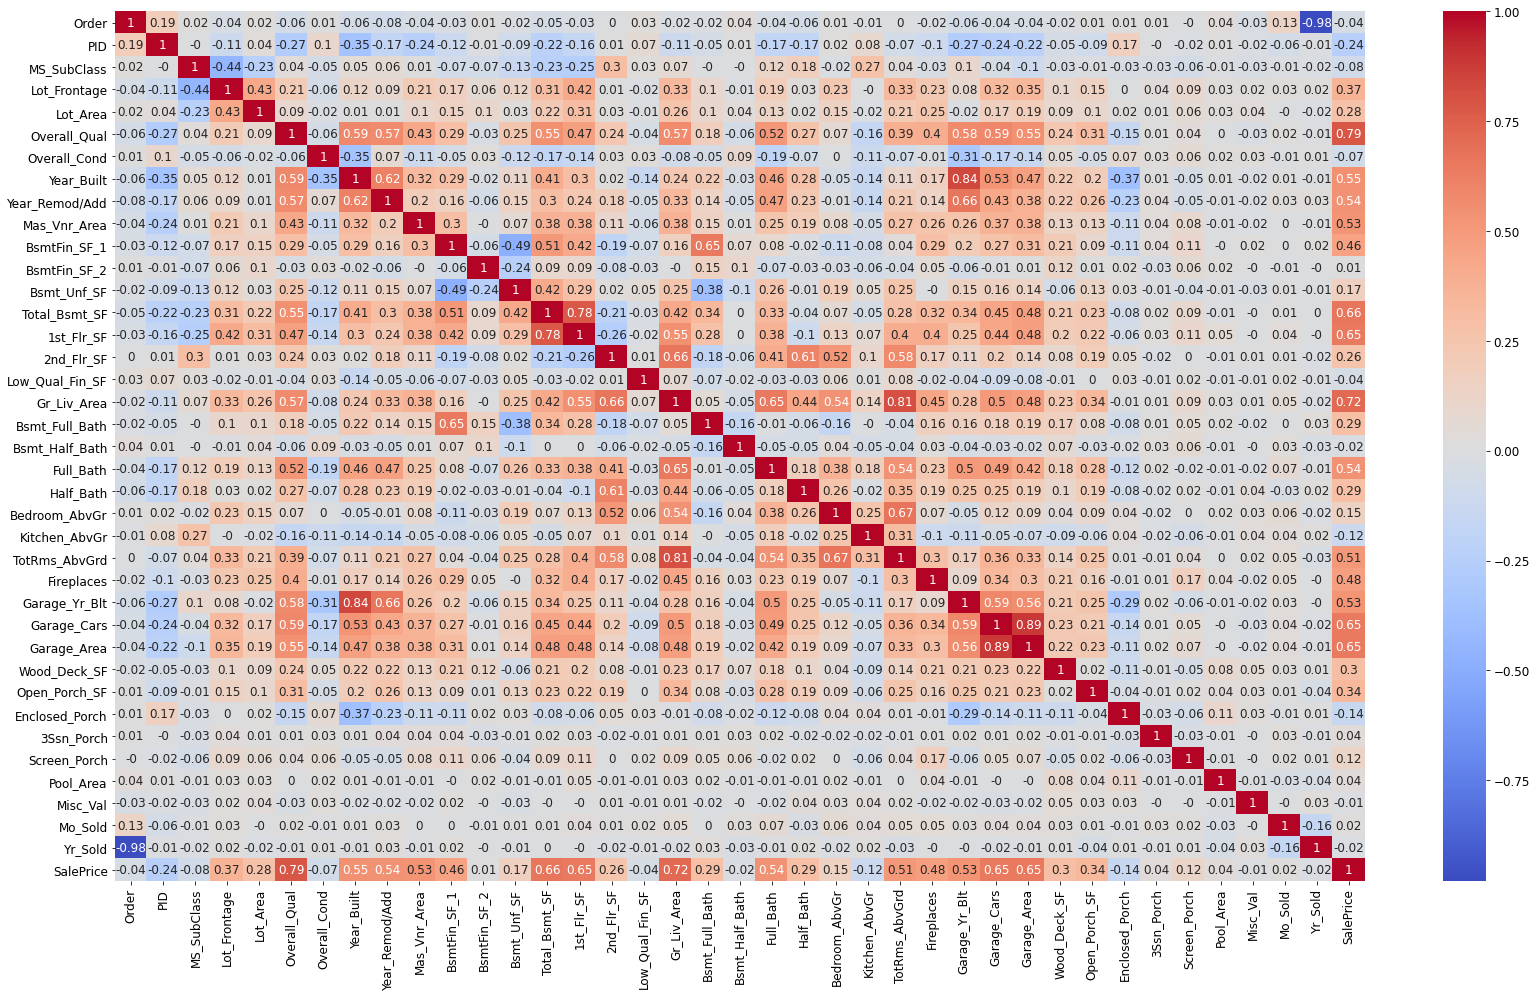

In [112]:
plt.figure(figsize=(28, 16))
corr_matrix = training_data_no_outliers.corr().round(2)
sns.heatmap(data=corr_matrix,cmap='coolwarm',annot=True)

Yr_Sold and Order are highly negatively correlated.
Sale_Price and Gr_Liv_Area, Year_Built and Garage_Year_Built 

# Part 2: Feature Engineering

In this section we will create a new feature out of existing ones through a simple data transformation.

### Bathrooms

Let's create a groundbreaking new feature. Due to recent advances in Universal WC Enumeration Theory, we now know that Total Bathrooms can be calculated as:

$$ \text{TotalBathrooms}=(\text{BsmtFullBath} + \text{FullBath}) + \dfrac{1}{2}(\text{BsmtHalfBath} + \text{HalfBath})$$


The function `add_total_bathrooms(data)`  returns a copy of `data` with an additional column called `TotalBathrooms` computed by the formula above. We treat missing values as zeros. 

<!--
BEGIN QUESTION
name: q2a
points: 2
-->

In [76]:
def add_total_bathrooms(data):
    """
    Input:
      data (data frame): a data frame containing at least 4 numeric columns 
            Bsmt_Full_Bath, Full_Bath, Bsmt_Half_Bath, and Half_Bath
    """
    with_bathrooms = data.copy()
    bath_vars = ['Bsmt_Full_Bath', 'Full_Bath', 'Bsmt_Half_Bath', 'Half_Bath']
    weights = pd.Series([1, 1, 0.5, 0.5], index=bath_vars)
    with_bathrooms['TotalBathrooms'] = (with_bathrooms.Bsmt_Full_Bath.fillna(0) + with_bathrooms.Full_Bath.fillna(0)) + (1/2)*(with_bathrooms.Bsmt_Half_Bath.fillna(0) + with_bathrooms.Half_Bath.fillna(0))
    return with_bathrooms

training_data_with_bathrooms = add_total_bathrooms(training_data_no_outliers)

<!-- BEGIN QUESTION -->

## Question 2b

We create a visualization that clearly and succintly shows that `TotalBathrooms` is associated with `SalePrice`. 

<!--
BEGIN QUESTION
name: q2b
points: 2
manual: True
-->

In [77]:
training_data_with_bathrooms

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,...,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2,528,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2,522,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2,482,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,2925,923251180,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,...,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2,576,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,124900,2.0
1996,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,...,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1984.0,Unf,2,588,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,136500,2.0
1997,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,...,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1983.0,Unf,2,484,TA,TA,Y,164,0,0,0,

Text(0.5, 1.0, 'Association between Totalbathrooms and saleprices')

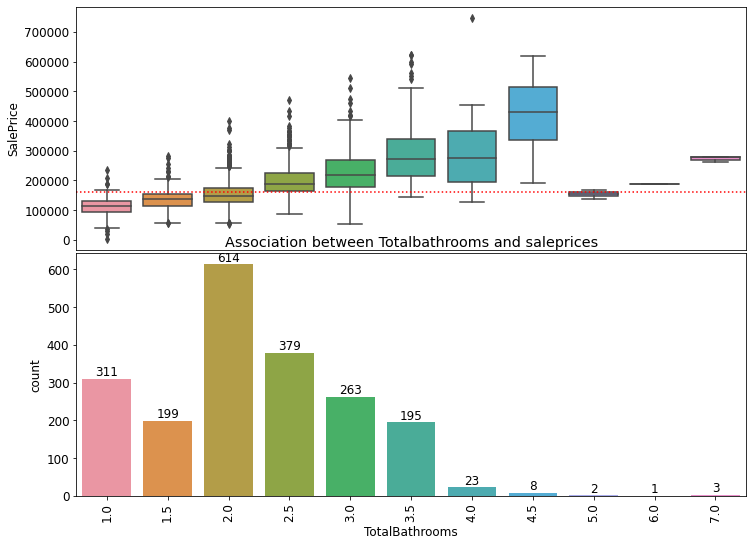

In [78]:

fig, axs = plt.subplots(nrows=2)

sns.boxplot(
    x='TotalBathrooms',
    y='SalePrice',
    data=training_data_with_bathrooms.sort_values('TotalBathrooms'),
    ax=axs[0]
)

sns.countplot(
    x='TotalBathrooms',
    data=training_data_with_bathrooms.sort_values('TotalBathrooms'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data_with_bathrooms['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)
plt.title("Association between Totalbathrooms and saleprices")

<!-- END QUESTION -->



# Part 3: Modeling

We've reached the point where we can specify a model. But first, we will load a fresh copy of the data, just in case our code above produced any undesired side-effects. We store a fresh copy of the data from `ames_train.csv` in a dataframe named `full_data`. We will also store the number of rows in `full_data` in the variable `full_data_len`.

In [79]:
# Load a fresh copy of the data and get its length
full_data = pd.read_csv("ames_train.csv")
full_data_len = len(full_data)
full_data.head()

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,...,Central_Air,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,Y,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2,528,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,Y,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2,522,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2,482,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700


## Question 3

Now, let's split the data set into a training set and a validation set. We will use the training set to fit our model's parameters, and we will use the validation set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on unseen data.

"Don't we already have a test set in `ames_test.csv`?" you might wonder. The sale prices for `ames_test.csv` aren't provided, so we're constructing our own validation set for which we know the outputs. Regardless, we shouldn't touch our test set until our model is finalized, even if the test outputs were available.

In the cell below, split the data in `full_data` into two DataFrames named `train` and `val`. Let `train` contain 80% of the data, and let `val` contain the remaining 20% of the data. 

Use the `train_test_split` function from `sklearn.model_selection` to perform this split. Use a `random_state` of 42 as an argument to `train_test_split`. 


<!--
BEGIN QUESTION
name: q3
points: 1
-->

In [80]:
from sklearn.model_selection import train_test_split

np.random.seed(42) 

# Split the data 
train, val = train_test_split(full_data, test_size=0.2)

### Reusable Pipeline

Throughout this notebook, you should notice that your data flows through a single processing pipeline several times.  From a software engineering perspective, it's best to define functions/methods that can apply the pipeline to any dataset.  We will now encapsulate our entire pipeline into a single function `process_data_gm`.  gm is shorthand for "guided model". We select a handful of features to use from the many that are available.

In [81]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    data = remove_outliers(data, 'Gr_Liv_Area', upper=5000)
    
    # Transform Data, Select Features
    data = add_total_bathrooms(data)
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

Now, we can use `process_data_gm` to clean our data, select features, and add our `TotalBathrooms` feature all in one step! This function also splits our data into `X`, a matrix of features, and `y`, a vector of sale prices. 

Run the cell below to feed our training and validation data through the pipeline, generating `X_train`, `y_train`, `X_val`, and `y_val`.

In [82]:
# Pre-process our training and validation data in exactly the same way
# Our functions make this very easy!
X_train, y_train = process_data_gm(train)
X_val, y_val = process_data_gm(val)

### Fitting Our First Model

We are finally going to fit a model!  The model we will fit can be written as follows:

$$\text{SalePrice} = \theta_0 + \theta_1 \cdot \text{Gr}\_\text{Liv}\_\text{Area} + \theta_2 \cdot \text{Garage}\_\text{Area} + \theta_3 \cdot \text{TotalBathrooms}$$

In vector notation, the same equation would be written:

$$y = \vec\theta \cdot \vec{x}$$

where $y$ is the SalePrice, $\vec\theta$ is a vector of all fitted weights, and $\vec{x}$ contains a 1 for the bias followed by each of the feature values.

**Note:** Notice that all of our variables are continuous, except for `TotalBathrooms`, which takes on discrete ordered values (0, 0.5, 1, 1.5, ...). We'll treat `TotalBathrooms` as a continuous quantitative variable in our model for now, but this might not be the best choice. The latter half of this notebook may revisit the issue.

## Question 4a

We will use a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. In the cell below, we create a `LinearRegression` object and name it `linear_model`.


<!--
BEGIN QUESTION
name: q4a
points: 1
-->

In [83]:
from sklearn import linear_model as lm

linear_model = lm.LinearRegression(fit_intercept=True)

## Question 4b <a name="q7b"></a>

Now, remove the commenting and fill in the ellipses `...` below with `X_train`, `y_train`, `X_val,` or `y_val`.

With the ellipses filled in correctly, the code below should fit our linear model to the training data and generate the predicted sale prices for both the training and validation datasets.

Assign your predictions for the training set to `y_fitted` and your predictions to the validation set to `y_predicted`.

*The provided tests check that you answered correctly, so that future analyses are not corrupted by a mistake.*

<!--
BEGIN QUESTION
name: q4b
points: 2
-->

In [84]:
# Uncomment the lines below and fill in the ... with X_train, y_train, X_test, or y_test.
linear_model.fit(X_train, y_train)
y_fitted = linear_model.predict(X_train)
y_predicted = linear_model.predict(X_val)

## Question 5a

Is our linear model any good at predicting house prices? Let's measure the quality of our model by calculating the Root-Mean-Square Error (RMSE) between our predicted house prices and the true prices stored in `SalePrice`.

$$\text{RMSE} = \sqrt{\dfrac{\sum_{\text{houses in dataset}}(\text{actual price of house} - \text{predicted price of house})^2}{\text{number of houses in dataset}}}$$


<!--
BEGIN QUESTION
name: q5a
points: 1
-->

In [85]:
def rmse(actual, predicted):
    """
    Calculates RMSE from actual and predicted values
    Input:
      actual (1D array): vector of actual values
      predicted (1D array): vector of predicted/fitted values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.sum(np.power(actual - predicted, 2))/len(actual))

## Question 5b <a name="q8b"></a>

Now use your `rmse` function to calculate the training error and validation error in the cell below.

*The provided tests for this question do not confirm that you have answered correctly; only that you have assigned each variable to a non-negative number.*

<!--
BEGIN QUESTION
name: q5b
points: 1
-->

In [86]:
X_val

,Gr_Liv_Area,Garage_Area,TotalBathrooms
1860,1453,445,2.5
353,2232,623,3.5
1333,960,308,1.0
905,1716,672,2.0
1289,2380,596,2.5
...,...,...,...
965,1418,558,3.0
1284,670,0,2.0
1739,1246,441,2.0
261,1360,565,2.0


In [87]:
training_error = rmse(y_train,y_fitted)
y_predicted = linear_model.predict(X_val)
val_error = rmse(y_predicted, y_val)
(training_error, val_error)

(46972.97146133178, 45011.261500075794)

## Question 5c

How much does including `TotalBathrooms` as a predictor reduce the RMSE of the model on the validation set? That is, what's the difference between the RSME of a model that only includes `Gr_Liv_Area` and `Garage_Area` versus one that includes all three predictors?

<!--
BEGIN QUESTION
name: q5c
points: 2
-->

In [88]:
X_train_no_bath = X_train.drop('TotalBathrooms', axis = 1)
X_val = X_val.drop('TotalBathrooms', axis = 1)
linear_model.fit(X_train_no_bath, y_train)
#y_fitted = linear_model.predict(X_train)
#y_predicted = linear_model.predict(X_val)
#training_error = rmse(y_train,y_fitted)
#val_error = rmse(y_predicted, y_val)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [89]:
X_train_no_bath = X_train.drop('TotalBathrooms',axis=1)
X_val
val_error_difference = rmse(linear_model.predict(X_val),y_val)- val_error
val_error_difference

2362.9903051712245

### Residual Plots

One way of understanding the performance (and appropriateness) of a model is through a residual plot. Run the cell below to plot the actual sale prices against the residuals of the model for the validation data.

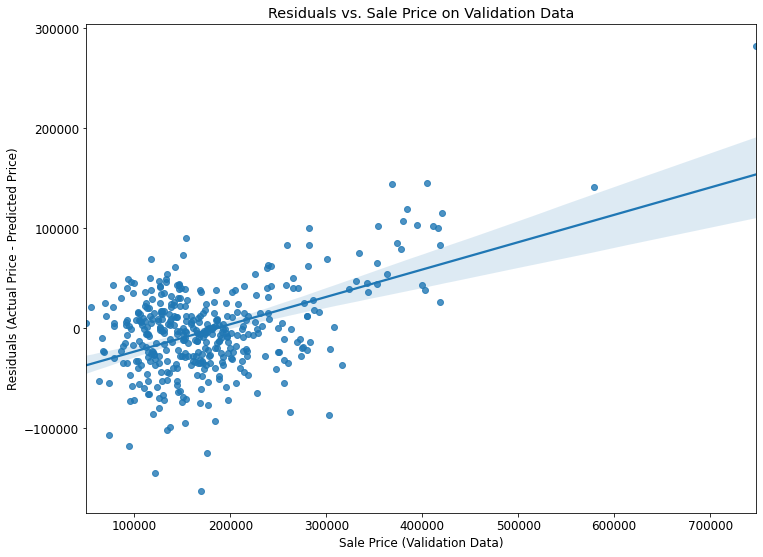

In [90]:
residuals = y_val - y_predicted
ax = sns.regplot(y_val, residuals)
ax.set_xlabel('Sale Price (Validation Data)')
ax.set_ylabel('Residuals (Actual Price - Predicted Price)')
ax.set_title("Residuals vs. Sale Price on Validation Data");

Ideally, we would see a horizontal line of points at 0 (perfect prediction!). The next best thing would be a homogenous set of points centered at 0. 

But alas, our simple model is probably too simple. The most expensive homes are systematically more expensive than our prediction.

We can also increase features to improve model complexity. We can use a regularization technique or cross-validation like LASSO/Ridge to prevent overfitting. We can couple this with Boosting to improve accuracy as well.

<!-- END QUESTION -->



# Part 4: More Feature Selection and Engineering

The linear model that we created failed to produce accurate estimates of the observed housing prices because the model was too simple. 

In this section, we identify two more features of the dataset that will increase our linear regression model's accuracy. Additionally, we will implement one-hot encoding so that we can include binary and categorical variables in our improved model.

We've used a slightly modified data cleaning pipeline from the first half of the assignment to prepare the training data. This data is stored in `ames_train_cleaned.csv`. It consists of 1998 observations and 83 features (we added the feature `TotalBathrooms` from the first half of the assignment). 

In [91]:
training_data_cleaned = pd.read_csv("ames_train_cleaned.csv")

## Question 6: Neighborhood vs Sale Price

First, let's take a look at the relationship between neighborhood and sale prices of the houses in our data set.

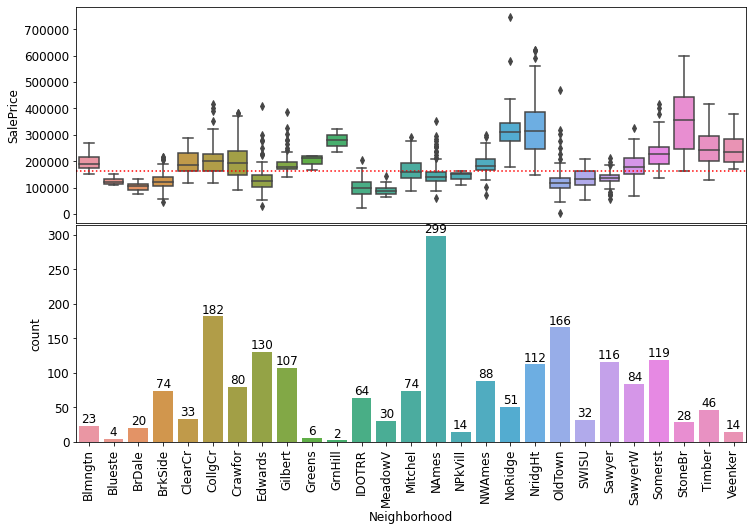

In [92]:
fig, axs = plt.subplots(nrows=2, figsize=(12, 8))

sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=training_data_cleaned.sort_values('Neighborhood'),
    ax=axs[0]
)

sns.countplot(
    x='Neighborhood',
    data=training_data_cleaned.sort_values('Neighborhood'),
    ax=axs[1]
)

# Draw median price
axs[0].axhline(
    y=training_data_cleaned['SalePrice'].median(), 
    color='red',
    linestyle='dotted'
)

# Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')
    
# Format x-axes
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
axs[0].xaxis.set_visible(False)

# Narrow the gap between the plots
plt.subplots_adjust(hspace=0.01)

In general, it appears that neighborhoods with more count of houses have lower sales prices than their counterparts.

<!-- END QUESTION -->

## Question 6b

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together.  Let's categorize our neighborhoods in a crude way: we'll take the top 3 neighborhoods measured by median `SalePrice` and identify them as "rich neighborhoods". We won't mark the other neighborhoods.

We write a function that returns list of the top n most pricy neighborhoods as measured by our choice of aggregating function.  For example, in the setup above, we would want to call `find_rich_neighborhoods(training_data_cleaned, 3, np.median)` to find the top 3 neighborhoods measured by median `SalePrice`.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [93]:
training_data_cleaned

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,...,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,SBrkr,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2,528,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,SBrkr,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2,522,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2,482,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,2925,923251180,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,...,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2,576,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,124900,2.0
1994,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,...,SBrkr,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1984.0,Unf,2,588,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,136500,2.0
1995,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,...,SBrkr,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1983.0,Unf,2,484,TA,TA,Y,164,0,0,0,

In [94]:
def find_rich_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (data frame): should contain at least a string-valued Neighborhood
        and a numeric SalePrice column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the top n richest neighborhoods as measured by the metric function
    """
    neighborhoods = data[['Neighborhood','SalePrice','TotalBathrooms']].groupby('Neighborhood',as_index=False).aggregate(metric).sort_values(by='SalePrice',ascending=False)
    neighborhoods = neighborhoods.iloc[:n]['Neighborhood'].values.tolist()
    return neighborhoods

rich_neighborhoods = find_rich_neighborhoods(training_data_cleaned, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']


We now have a list of neighborhoods we've deemed as richer than others.  Let's use that information to make a new variable `in_rich_neighborhood`.  Write a function `add_rich_neighborhood` that adds an indicator variable which takes on the value 1 if the house is part of `rich_neighborhoods` and the value 0 otherwise.


<!--
BEGIN QUESTION
name: q6c
points: 1
-->

In [95]:
def add_in_rich_neighborhood(data, neighborhoods):
    """
    Input:
      data (data frame): a data frame containing a 'Neighborhood' column with values
        found in the codebook
      neighborhoods (list of strings): strings should be the names of neighborhoods
        pre-identified as rich
    Output:
      data frame identical to the input with the addition of a binary
      in_rich_neighborhood column
    """
    data_copy = data.copy()
    data_copy['in_rich_neighborhood'] = data_copy['Neighborhood'].isin(neighborhoods).astype(dtype='int64')
    return data_copy

rich = find_rich_neighborhoods(training_data_cleaned, 3, np.median)
training_data_rich = add_in_rich_neighborhood(training_data_cleaned, rich)

Let's see if our data set has any missing values.  Create a Series object containing the counts of missing values in each of the columns of our data set, sorted from greatest to least.  The Series should be indexed by the variable names.  For example, `missing_counts.loc['Fireplace_Qu']` should return 975.


<!--
BEGIN QUESTION
name: q7a
points: 1
-->

In [96]:
missing_counts = training_data_rich.isnull().sum().sort_values(ascending=False)
missing_counts

Pool_QC            1991
Misc_Feature       1922
Alley              1865
Fence              1607
Fireplace_Qu        975
                   ... 
Low_Qual_Fin_SF       0
2nd_Flr_SF            0
1st_Flr_SF            0
Central_Air           0
Order                 0
Length: 84, dtype: int64

It turns out that if we look at the codebook carefully, some of these "missing values" aren't missing at all! The Assessor's Office just used `NA` to denote a special value or that the information was truly not applicable for one reason or another.  One such example is the `Fireplace_Qu` variable.
```
FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace inbasement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace
```


An `NA` here actually means that the house had no fireplace to rate.  Let's fix this in our data set.  We write a function that replaces the missing values in `Fireplace_Qu` with `'No Fireplace'`.  In addition, it should replace each abbreviated condition with its full word.  For example, `'TA'` should be changed to `'Average'`.  


<!--
BEGIN QUESTION
name: q7b
points: 2
-->

In [97]:
def fix_fireplace_qu(data):
    """
    Input:
      data (data frame): a data frame containing a Fireplace_Qu column.  Its values
                         should be limited to those found in the codebook
    Output:
      data frame identical to the input except with a refactored Fireplace_Qu column
    """
    replace_dict = {'Ex': 'Excellent', 'Gd': 'Good', 'TA': 'Average', 'Fa': 'Fair', 'Po': 'Poor'}
    new_data = data.replace(to_replace={'Fireplace_Qu': replace_dict})
    new_data['Fireplace_Qu'] = new_data['Fireplace_Qu'].fillna('No Fireplace')
    return new_data
    
training_data_qu = fix_fireplace_qu(training_data_rich)
training_data_rich

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,...,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,SalePrice,TotalBathrooms,in_rich_neighborhood
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1960,1960,Hip,CompShg,BrkFace,Plywood,Stone,112.0,TA,TA,CBlock,TA,Gd,Gd,BLQ,639.0,Unf,0.0,441.0,1080.0,...,1656,0,0,1656,1.0,0.0,1,0,3,1,TA,7,Typ,2,Gd,Attchd,1960.0,Fin,2,528,TA,TA,P,210,62,0,0,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal,204900,2.0,0
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,...,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1,730,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,95300,1.0,0
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,...,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1,312,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,181900,1.5,0
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,7,5,1968,1968,Hip,CompShg,BrkFace,BrkFace,None,0.0,Gd,TA,CBlock,TA,TA,No,ALQ,1065.0,Unf,0.0,1045.0,2110.0,...,2110,0,0,2110,1.0,0.0,2,1,3,1,Ex,8,Typ,2,TA,Attchd,1968.0,Fin,2,522,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal,254100,3.5,0
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,...,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2,482,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,199700,2.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,2925,923251180,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,...,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2,576,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,124900,2.0,0
1994,2926,923275080,80,RL,37.0,7937,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,SLvl,6,6,1984,1984,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,Av,GLQ,819.0,Unf,0.0,184.0,1003.0,...,1003,0,0,1003,1.0,0.0,1,0,3,1,TA,6,Typ,0,NaN,Detchd,1984.0,Unf,2,588,TA,TA,Y,120,0,0,0,0,0,NaN,GdPrv,NaN,0,3,2006,WD,Normal,136500,2.0,0
1995,2927,923276100,20,RL,NaN,8885,Pave,NaN,IR1,Low,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1983,1983,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,Gd,TA,Av,BLQ,301.0,ALQ,324.0,239.0,864.0,...,902,0,0,902,1.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1983.0,Unf,2,484,TA,TA,Y,164,0,0,0,0,0,NaN,MnPrv,NaN,0,6,20

In [98]:
training_data_qu['Fireplace_Qu']

0               Good
1       No Fireplace
2       No Fireplace
3            Average
4            Average
            ...     
1993         Average
1994    No Fireplace
1995    No Fireplace
1996    No Fireplace
1997         Average
Name: Fireplace_Qu, Length: 1998, dtype: object

### An Important Note on One Hot Encoding <a name="important_note"></a>

Unfortunately, simply fixing these missing values isn't sufficient for using `Fireplace_Qu` in our model.  Since `Fireplace_Qu` is a categorical variable, we will have to one-hot-encode the data using `DictVectorizer`. Note that we dropped the first one-hot-encoded column. For more information on categorical data in pandas, refer to this [link](https://pandas-docs.github.io/pandas-docs-travis/categorical.html).

In [99]:
def ohe_fireplace_qu(data):
    """
    One-hot-encodes fireplace quality.  New columns are of the form Fireplace_Qu=QUALITY
    """
    vec_enc = DictVectorizer()
    vec_enc.fit(data[['Fireplace_Qu']].to_dict(orient='records'))
    fireplace_qu_data = vec_enc.transform(data[['Fireplace_Qu']].to_dict(orient='records')).toarray()
    fireplace_qu_cats = vec_enc.get_feature_names()
    fireplace_qu = pd.DataFrame(fireplace_qu_data, columns=fireplace_qu_cats)
    data = pd.concat([data, fireplace_qu], axis=1)
    data = data.drop(columns=fireplace_qu_cats[0])
    return data

In [100]:
training_data_ohe = ohe_fireplace_qu(training_data_qu)
training_data_ohe.filter(regex='Fireplace_Qu').head(10)

,Fireplace_Qu,Fireplace_Qu=Excellent,Fireplace_Qu=Fair,Fireplace_Qu=Good,Fireplace_Qu=No Fireplace,Fireplace_Qu=Poor
0,Good,0.0,0.0,1.0,0.0,0.0
1,No Fireplace,0.0,0.0,0.0,1.0,0.0
2,No Fireplace,0.0,0.0,0.0,1.0,0.0
3,Average,0.0,0.0,0.0,0.0,0.0
4,Average,0.0,0.0,0.0,0.0,0.0
5,Good,0.0,0.0,1.0,0.0,0.0
6,No Fireplace,0.0,0.0,0.0,1.0,0.0
7,Average,0.0,0.0,0.0,0.0,0.0
8,No Fireplace,0.0,0.0,0.0,1.0,0.0
9,Good,0.0,0.0,1.0,0.0,0.0


# Part 5: Improved Linear Models

In this section, we will create linear models that produce more accurate estimates of the housing prices in Ames than the model created in the first half of this notebook, but at the expense of increased complexity.

## Adding Covariates to our Model

It's finally time to fit our updated linear regression model using the ordinary least squares estimator! Our new model consists of the linear model from the first half of this assignment, with the addition of the our newly created `in_rich_neighborhood` variable and our one-hot-encoded fireplace quality variables:

$$
\begin{aligned}
\text{SalePrice} & = \theta_0 + \theta_1 \cdot \text{Gr}\_\text{Liv}\_\text{Area} + \theta_2 \cdot \text{Garage}\_\text{Area} + 
\theta_3 \cdot \text{TotalBathrooms} + \theta_4 \cdot \text{in}\_\text{rich}\_\text{neighborhood} + \\
& \quad \: \theta_5 \cdot I(\text{Fireplace}\_\text{Qu=Excellent}) + \theta_6 \cdot I(\text{Fireplace}\_\text{Qu=Fair}) + \theta_7 \cdot I(\text{Fireplace}\_\text{Qu=Good}) + \\
& \quad \: \theta_8 \cdot I(\text{Fireplace}\_\text{Qu=No Fireplace}) + \theta_9 \cdot I(\text{Fireplace}\_\text{Qu=Poor})
\end{aligned}
$$

<!-- BEGIN QUESTION -->


Although the fireplace quality variable that we explored earlier has six categories, only five of these categories' indicator variables are included in our model. Is this a mistake, or is it done intentionally? Why?

<!--
BEGIN QUESTION
name: q8a
points: 1
manual: True
-->

The "Average" feature is not required in this formula and hence it is removed to avoid linear dependence due to the constant term.

<!-- END QUESTION -->



We still have a little bit of work to do prior to esimating our linear regression model's coefficients. Instead of having you go through the process of selecting the pertinent convariates and creating a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for our linear model again, we will provide the necessary code from the first half of this assignment. However, we will now use cross validation to help validate our model instead of explicitly splitting the data into a training and validation set.

First, we will re-import the data.

In [101]:
new_training_data = pd.read_csv("ames_train_cleaned.csv")

Next, we will implement a reusable pipeline that selects the required variables in our data and splits our covariates and response variable into a matrix and a vector, respectively.

In [102]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def process_data_gm(data):
    """Process the data for a guided model."""
    # One-hot-encode fireplace quality feature
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'Fireplace_Qu=Excellent',
                          'Fireplace_Qu=Fair',
                          'Fireplace_Qu=Good',
                          'Fireplace_Qu=No Fireplace',
                          'Fireplace_Qu=Poor'
                         )
    
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    
    return X, y

We then process our training set using our data cleaning pipeline.

In [103]:
# Pre-process the training data
# Our functions make this very easy!
X_train_gm, y_train_gm = process_data_gm(new_training_data)
X_train_gm.head()

,Gr_Liv_Area,Garage_Area,TotalBathrooms,in_rich_neighborhood,Fireplace_Qu=Excellent,Fireplace_Qu=Fair,Fireplace_Qu=Good,Fireplace_Qu=No Fireplace,Fireplace_Qu=Poor
0,1656,528,2.0,0,0.0,0.0,1.0,0.0,0.0
1,896,730,1.0,0,0.0,0.0,0.0,1.0,0.0
2,1329,312,1.5,0,0.0,0.0,0.0,1.0,0.0
3,2110,522,3.5,0,0.0,0.0,0.0,0.0,0.0
4,1629,482,2.5,0,0.0,0.0,0.0,0.0,0.0


Finally, we initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object as our linear model. We set the `fit_intercept=True` to ensure that the linear model has a non-zero intercept.

In [104]:
from sklearn import linear_model as lm

linear_model_gm = lm.LinearRegression(fit_intercept=True)

After a little bit of work, it's finally time to fit our updated linear regression model. The cell below estimates the model and then uses it to compute the fitted value of `SalePrice` over the training data.

In [105]:
# Fit the model
linear_model_gm.fit(X_train_gm, y_train_gm)

# Compute the fitted and predicted values of SalePrice
y_fitted_gm = linear_model_gm.predict(X_train_gm)

Let's assess the performance of our new linear regression model using the Root Mean Squared Error function from earlier in this assignment.

In [106]:
training_error_gm = rmse(y_fitted_gm, y_train_gm)
print("Training RMSE: {}".format(training_error_gm))

Training RMSE: 40118.93633164243


A slighlty modified version of the `cross_validate_rmse` function from is provided below.

In [107]:
from sklearn.model_selection import KFold
from sklearn.base import clone

def cross_validate_rmse(model, X, y):
    model = clone(model)
    five_fold = KFold(n_splits=5)
    rmse_values = []
    for tr_ind, va_ind in five_fold.split(X):
        model.fit(X.iloc[tr_ind,:], y.iloc[tr_ind])
        rmse_values.append(rmse(y.iloc[va_ind], model.predict(X.iloc[va_ind,:])))
    return np.mean(rmse_values)

We use the `cross_validate_rmse` function to calculate the cross validation error in the cell below.

<!--
BEGIN QUESTION
name: q8b
points: 1
-->

In [108]:
cv_error_gm = cross_validate_rmse(linear_model_gm,X_train_gm, y_train_gm)
print("Cross Validation RMSE: {}".format(cv_error_gm))

Cross Validation RMSE: 40346.2672678042


Just as in the guided model above, we should encapsulate as much of your workflow into functions as possible. Below, we have initialized `final_model` for you. Your job is to select better features and define your own feature engineering pipeline in `process_data_fm`. We recommend using cross validation to help inform your feature selection process.

To evaluate the model, we will process training data using your `process_data_fm`, fit `final_model` with this training data, and compute the training RMSE. Then, we will process the test data with your `process_data_fm`, use `final_model` to predict sale prices for the test data, and compute the test RMSE. See below for an example of the code run to evaluate your model:

```
training_data_fm = pd.read_csv('ames_train_cleaned.csv')
test_data_fm = pd.read_csv('ames_test_cleaned.csv')

X_train_fm, y_train_fm = process_data_fm(training_data_fm)
X_test_fm, y_test_fm = process_data_fm(test_data_fm)

final_model.fit(X_train_fm, y_train_fm)
y_predicted_train_fm = final_model.predict(X_train_fm)
y_predicted_test_fm = final_model.predict(X_test_fm)

training_rmse_fm = rmse(y_predicted_train_fm, y_train_fm)
test_rmse_fm = rmse(y_predicted_test_fm, y_test_fm)
```

<!--
BEGIN QUESTION
name: q9
points: 4
-->

In [109]:
test_data_fm = pd.read_csv('ames_test_cleaned.csv')
data = fix_fireplace_qu(test_data_fm)
data = data.fillna(0)
data

,Order,PID,MS_SubClass,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,Condition_2,Bldg_Type,House_Style,Overall_Qual,Overall_Cond,Year_Built,Year_Remod/Add,Roof_Style,Roof_Matl,Exterior_1st,Exterior_2nd,Mas_Vnr_Type,Mas_Vnr_Area,Exter_Qual,Exter_Cond,Foundation,Bsmt_Qual,Bsmt_Cond,Bsmt_Exposure,BsmtFin_Type_1,BsmtFin_SF_1,BsmtFin_Type_2,BsmtFin_SF_2,Bsmt_Unf_SF,Total_Bsmt_SF,...,Electrical,1st_Flr_SF,2nd_Flr_SF,Low_Qual_Fin_SF,Gr_Liv_Area,Bsmt_Full_Bath,Bsmt_Half_Bath,Full_Bath,Half_Bath,Bedroom_AbvGr,Kitchen_AbvGr,Kitchen_Qual,TotRms_AbvGrd,Functional,Fireplaces,Fireplace_Qu,Garage_Type,Garage_Yr_Blt,Garage_Finish,Garage_Cars,Garage_Area,Garage_Qual,Garage_Cond,Paved_Drive,Wood_Deck_SF,Open_Porch_SF,Enclosed_Porch,3Ssn_Porch,Screen_Porch,Pool_Area,Pool_QC,Fence,Misc_Feature,Misc_Val,Mo_Sold,Yr_Sold,Sale_Type,Sale_Condition,TotalBathrooms,SalePrice
0,7,527127150,120,RL,41.0,4920,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,2001,2001,Gable,CompShg,CemntBd,CmentBd,None,0.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,616,Unf,0,722,1338,...,SBrkr,1338,0,0,1338,1,0,2,0,2,1,Gd,6,Typ,0,No Fireplace,Attchd,2001.0,Fin,2.0,582.0,TA,TA,Y,0,0,170,0,0,0,0,0,0,0,4,2010,WD,Normal,3.0,213500
1,10,527162130,60,RL,60.0,7500,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,1999,1999,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,TA,TA,No,Unf,0,Unf,0,994,994,...,SBrkr,1028,776,0,1804,0,0,2,1,3,1,Gd,7,Typ,1,Average,Attchd,1999.0,Fin,2.0,442.0,TA,TA,Y,140,60,0,0,0,0,0,0,0,0,6,2010,WD,Normal,2.5,189000
2,11,527163010,60,RL,75.0,10000,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,763,763,...,SBrkr,763,892,0,1655,0,0,2,1,3,1,TA,7,Typ,1,Average,Attchd,1993.0,Fin,2.0,440.0,TA,TA,Y,157,84,0,0,0,0,0,0,0,0,4,2010,WD,Normal,2.5,175900
3,15,527182190,120,RL,0.0,6820,Pave,0,IR1,Lvl,AllPub,Corner,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1985,1985,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,Av,GLQ,368,BLQ,1120,0,1488,...,SBrkr,1502,0,0,1502,1,0,1,1,1,1,Gd,4,Typ,0,No Fireplace,Attchd,1985.0,RFn,2.0,528.0,TA,TA,Y,0,54,0,0,140,0,0,0,0,0,6,2010,WD,Normal,2.5,212000
4,16,527216070,60,RL,47.0,53504,Pave,0,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,...,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Good,BuiltIn,2003.0,Fin,3.0,841.0,TA,TA,Y,503,36,0,0,210,0,0,0,0,0,6,2010,WD,Normal,4.5,538000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
925,2916,923227100,20,RL,80.0,13384,Pave,0,Reg,Lvl,AllPub,Inside,Mod,Mitchel,Norm,Norm,1Fam,1Story,5,5,1969,1979,Gable,CompShg,Plywood,Plywood,BrkFace,194.0,TA,TA,PConc,TA,TA,Av,Rec,119,BLQ,344,641,1104,...,SBrkr,1360,0,0,1360,1,0,1,0,3,1,TA,8,Typ,1,Average,Attchd,1969.0,RFn,1.0,336.0,TA,TA,Y,160,0,0,0,0,0,0,0,0,0,5,2006,WD,Normal,2.0,140000
926,2921,923228310,160,RM,21.0,1894,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252,Unf,0,294,546,...,SBrkr,546,546,0,1092,0,0,1,1,3,1,TA,6,Typ,0,No Fireplace,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,0,0,0,0,4,2006,WD,Abnorml,1.5,71000
927,2922,923229110,90,RL,55.0,12640,Pave,0,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,Duplex,1Story,6,5,1976,1976,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,TA,TA,Gd,Rec,936,LwQ,396,396,1728,...,SBrkr,1728,0,0,1728,0,0,2,0,4,2,TA,8,Typ,0,No Fireplace,Attchd,1976.0,Unf,2.0,574.0,TA,TA,Y,40,0,0,0,0,0,0,0,0,0,7,2006,WD,Normal,2.0,150900
928,2924,92

In [110]:
def process_data_fm(data):
    data = data.fillna(0)
    data = fix_fireplace_qu(data)
    data = ohe_fireplace_qu(data)
    
    # Use rich_neighborhoods computed earlier to add in_rich_neighborhoods feature
    data = add_in_rich_neighborhood(data, rich_neighborhoods)
    # Transform Data, Select Features
    data = select_columns(data, 
                          'SalePrice', 
                          'Gr_Liv_Area', 
                          'Garage_Area',
                          'TotalBathrooms',
                          'in_rich_neighborhood',
                          'Fireplace_Qu=Excellent',
                          'Fireplace_Qu=Fair',
                          'Fireplace_Qu=Good',
                          #'Fireplace_Qu=No Fireplace',
                          'Fireplace_Qu=Poor',
                          'Overall_Qual',
                          'Overall_Cond'
                         )
    #data = data.fillna(0)
    # Return predictors and response variables separately
    X = data.drop(['SalePrice'], axis = 1)
    y = data.loc[:, 'SalePrice']
    y.fillna(0)
    X.fillna(0)
    return X, y

final_model = lm.LinearRegression(fit_intercept=True) # No need to change this!

training_data_fm = pd.read_csv('ames_train_cleaned.csv')
test_data_fm = pd.read_csv('ames_test_cleaned.csv')

X_train_fm, y_train_fm = process_data_fm(training_data_fm)
X_test_fm, y_test_fm = process_data_fm(test_data_fm)


final_model.fit(X_train_fm, y_train_fm)
y_predicted_train_fm = final_model.predict(X_train_fm)
y_predicted_test_fm = final_model.predict(X_test_fm)

training_rmse_fm = rmse(y_predicted_train_fm, y_train_fm)
test_rmse_fm = rmse(y_predicted_test_fm, y_test_fm)
print(training_rmse_fm)
print(test_rmse_fm)

34765.18621269099
34842.53094872137


# An Ensemble Approach

The next step would be to create a base model first without any feature engineering and hyperparameter tuning. We would use this model’s performance as a benchmark for comparison later on after we have done feature engineering and hyperparameter tuning later.

The machine learning model we have chosen is the Random Forest Regression Model and here is why:
Random Forests models require minimal data preparation. It is able to easily hand categorical, numerical and binary features without scaling or normalization required.
Random Forests models can help us in performing implicit feature selections as they provide good indicators of the important features.
Random Forest models are immune to outliers, which is present in our data, and they completely ignore statistical issues because unlike other machine learning models which perform much better after being normalized.

In [114]:
# A function to split our training data into a training set to train our  model and a validations set, which will be used to validate our model.
def split_vals(a,n):
    return a[:n],a[n:]
# Functions that will help us calculate the RMSE and print the score.
def rmse(x,y):
    return math.sqrt(((x-y)**2).mean())
def print_score(m):
    res =[rmse(m.predict(X_train_fm),y_train_fm),rmse(m.predict(X_val),y_val),m.score(X_train_fm,y_train_fm),m.score(X_val,y_val)]
    if hasattr(m,'oob_score_'):res.append(m.oob_score_)
    print(res)

Creating and Fitting our Random Forest Model without hyperparameter tuning.

In [122]:
m = RandomForestRegressor(n_jobs = -1, oob_score = True)
m.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=True,
                      random_state=None, verbose=0, warm_start=False)

In [124]:
regressor  = XGBRegressor()
regressor.fit(X_train, y_train)

[03:03:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

We can see that our Regression model with Feature Engineering has beaten the Random Forest without Feature Engineering. A test with XGBoost was also done which achieved a similar accuracy but not nearly as good as our base model Regression. 

Conclusion: Feature Engineering matters more than complexifying models.